In [2]:
import numpy as np # Линейная алгерба + генератор случайных чисел
import matplotlib.pyplot as plt # для рисования
%matplotlib inline
np.random.seed(42) # для воспроизводимости результатов

In [3]:
d1 = 1.32 # параметр экспоненциального распр. для 1го врем. интервала
d2 = 1.2 # параметр экспоненциального распр. для 2го врем. интервала
CF0 = -3321 # Инвестиции
CF1 = (1988, 132) # Параметры денежного потока за 1 промежуток
CF2 = (2820, 150) # Параметры денежного потока за 2 промежуток
D = 0.15 # Дисконт
dD_range = (-0.02, 0.02) # промежуток для сэмплирования D
dD_params = (1,6) # параметры для распределения D

Рассчитаем NVP по формуле:

$$
NVP = CF_0 + \sum\limits_{i=1}^{n} \frac{CF_i}{(1+disc_i)^{\sum\limits_{j=1}^{i} t_j}}
$$

In [4]:
def NVP(cf_i, t_i, discount_i):

    NVP = cf_i[0] + sum(cf_i[1:]/(1+discount_i)**np.cumsum(t_i))
    
    return NVP

# np.cumsum(arr) - кумулятивная сумма массива arr

In [5]:
def experiment():
    """
    Возвращает значения всех параметров после сэмплирования
    """
    times = np.array([np.random.exponential(d1), 
                      np.random.exponential(d2)
                     ])
    
    CFs = np.array([CF0, 
                    CF1[0] + np.random.randn()*CF1[1], 
                    CF2[0] + np.random.randn()*CF2[1]
                   ])
    
    discounts = np.random.beta(*dD_params, 2)*(dD_range[1] - dD_range[0]) + dD_range[0] + D
    
    return CFs, times, discounts

In [6]:
num_experiments = 100000
nvps = []

for e in range(num_experiments):
    cf, time, disc = experiment()
    nvp = NVP(cf, time, disc)
    nvps.append(nvp)

In [7]:
print('Среднее значение NVP: {}\nСтандартное отклонение: {}'.format(np.mean(nvps), np.std(nvps)))

Среднее значение NVP: 473.9594664311993
Стандартное отклонение: 641.7837616773049


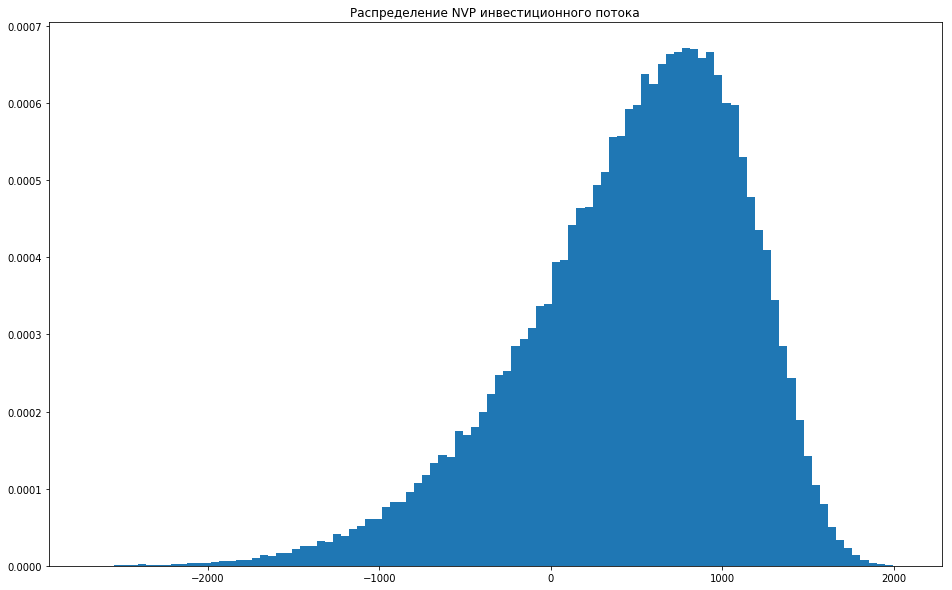

In [8]:
plt.figure(figsize=(16,10))
plt.hist(nvps, bins=100, density=True)
plt.title('Распределение NVP инвестиционного потока')
plt.show()

Посмотрим, что будет в детерминированном случае. Возьмем в качестве каждой из случайных величин их математические ожидания

In [9]:
cfs = np.array([CF0, CF1[0], CF2[0]])
times = np.array([1/d1, 1/d2])
discs = D + dD_range[0] + np.array([dD_params[0]/sum(dD_params)]*2)*(dD_range[1] - dD_range[0])
print(cfs, times, discs)

[-3321  1988  2820] [0.75757576 0.83333333] [0.13571429 0.13571429]


In [10]:
nvp = NVP(cfs, times, discs)
print('NVP в детерминированном случае:', nvp)

NVP в детерминированном случае: 787.4289302793986


В детерминированном случае NVP оказывается больше, чем при случайном сэмплировании.

Проверим теперь достаточность имитации, немного поиграв с параметрами, полученными в детерминированном случае. 

Добавим к CF случайную величину $~N(0, 1)$, к discount добавим $~N(0, 0.01)$, а к times $~N(0, 0.05)$

In [45]:
def play_with_params(cfs, times, discs):
    cfs_shifted = cfs + np.random.randn(len(cfs))*1.
    times_shifted = times + np.random.randn(len(times))*0.05
    disc_shifted = discs + np.random.randn(len(discs))*0.01
    return cfs_shifted, times_shifted, disc_shifted

cfs_shifted, times_shifted, disc_shifted = play_with_params(cfs, times, discs)
nvp_shifted = NVP(cfs_shifted, times_shifted, disc_shifted)

print('NPV с измененными параметрами:', nvp_shifted)

NPV с измененными параметрами: 792.7634291334134


Посмотрим на отклонения от детерминированного случая при варьировании параметров

Среднее значение NVP: -0.7282061740374124
Стандартное отклонение: 45.807604727724886


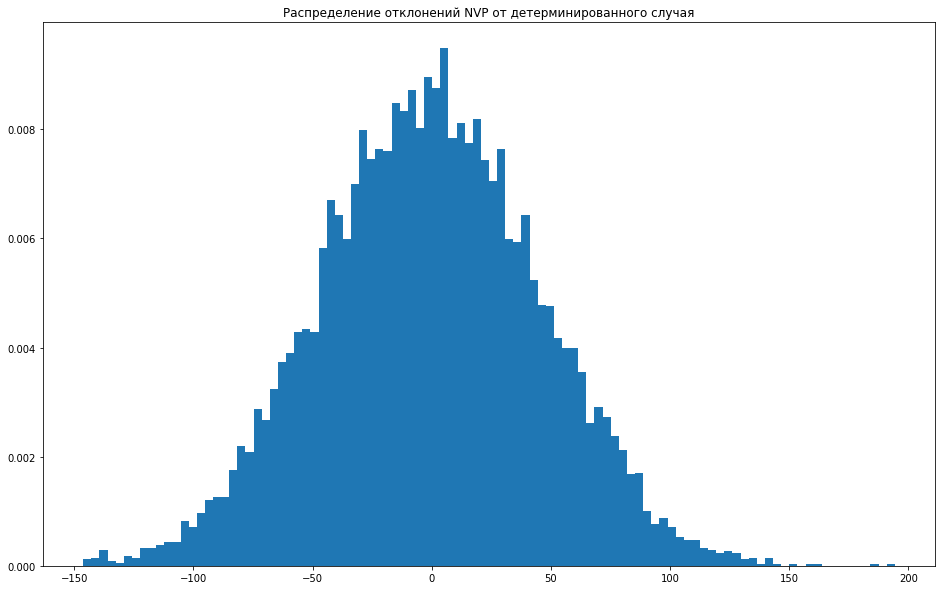

In [47]:
num_experiments = 10000
nvp_shifts = []

for e in range(num_experiments):
    
    nvp_shifted = NVP(*play_with_params(cfs, times, discs))
    nvp_shifts.append(nvp - nvp_shifted)
    

print('Среднее значение NVP: {}\nСтандартное отклонение: {}'.format(np.mean(nvp_shifts), np.std(nvp_shifts)))

plt.figure(figsize=(16,10))
plt.hist(nvp_shifts, bins=100, density=True)
plt.title('Распределение отклонений NVP от детерминированного случая')
plt.show()

Видим, что отклонения подчиняются нормальному закону. Выбросов нет. Значит, имитация достаточна.